Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │    35,828,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 128)        │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,408,389 (138.89 MB)

 Trainable params: 193,429 (755.58 KB)

 Non-trainable params: 35,828,100 (136.67 MB)

 Optimizer params: 386,860 (1.48 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Input: Can you recommend a restaurant?
Predicted probabilities: [[0.07804979]]
Predicted intent: 0


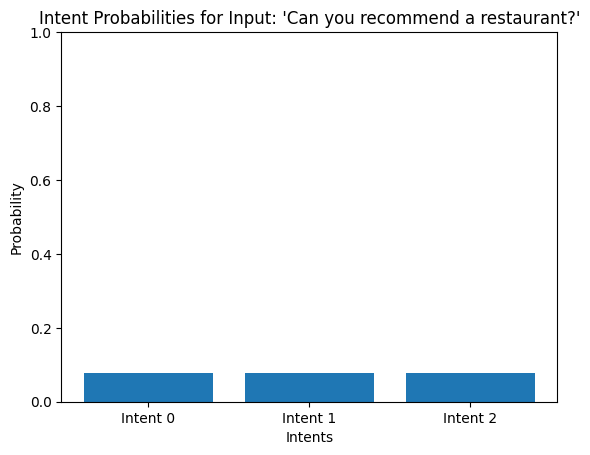

In [2]:
import numpy as np
import torch
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# Load GloVe embeddings
def load_glove_embeddings(glove_path, embedding_dim=300):
    embeddings_index = {}
    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                if len(coefs) == embedding_dim:
                    embeddings_index[word] = coefs
            except ValueError:
                pass
    return embeddings_index

# Convert text to GloVe vector
def text_to_glove_vector(text, embeddings_index, embedding_dim=300):
    tokens = text.lower().split()
    vectors = [embeddings_index.get(token, np.zeros(embedding_dim)) for token in tokens]
    return np.mean(vectors, axis=0)

# Load your trained model
model = load_model(f"../models/tier2_01_cnn_model_1736284036.keras") 
model.summary()

# Predict intent and plot probabilities
def predict_and_plot(user_input):
    glove_path = "../data/glove.840B.300d.txt"  # Replace with actual GloVe path
    embeddings_index = load_glove_embeddings(glove_path)
    
    glove_vector = text_to_glove_vector(user_input, embeddings_index)
    input_tensor = np.expand_dims(glove_vector, axis=0)
    
    prediction = model.predict(input_tensor)
    intent = np.argmax(prediction)
    
    # Print the probabilities
    print(f"Input: {user_input}")
    print(f"Predicted probabilities: {prediction}")
    print(f"Predicted intent: {intent}")
    
    # Plot the probabilities
    intents = ["Intent 0", "Intent 1", "Intent 2"]
    plt.bar(intents, prediction[0])
    plt.title(f"Intent Probabilities for Input: '{user_input}'")
    plt.ylabel("Probability")
    plt.xlabel("Intents")
    plt.ylim(0, 1)
    plt.show()

# Example usage
if __name__ == "__main__":
    user_input = "Can you recommend a restaurant?"  # Replace with any input
    predict_and_plot(user_input)


In [3]:
from dask.distributed import Client

client = Client()
print("Dask cluster details:", client)
client.close()

Dask cluster details: <Client: 'tcp://127.0.0.1:38901' processes=11 threads=22, memory=15.32 GiB>


In [4]:
client.close()

In [8]:
import dask.bag as db
import pandas as pd
client = Client()
data = pd.read_csv("../data/New_York_reviews_with_no_restaurantname_in_Review.csv") 
dask_bag = db.from_sequence(data['review_no_restaurant'].tolist(), npartitions=4)
matches = dask_bag.filter(lambda x: "italian" in x.lower()).compute()
#keyword_matches = dask_bag.filter(lambda x: cuisine.lower() in x.lower()).compute()
print(matches[:5])  # Use slicing instead of .head()
client.close()


/home/hyd_in_zrh/anaconda3/envs/textanalytics_env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39441 instead
  warnings.warn(
/home/hyd_in_zrh/anaconda3/envs/textanalytics_env/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 121.84 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


['co workers volunteering foodbank corner came lunch find awesome italian food unique twists standard fare atmosphere appealing prices reasonable especially manhattan wait staff awesome coming', 'nyc know italian reastaurants fake italian inside times quality best pasta actually handmade gnocchis find real italian truffles perfect service professional extraordinary wines piemonte region place clean nice little bit noisy taste stunning experience', 'girlfriend originally piedmont italy restaurant elegant nice atmosphere good fit romantic friends dinners food simply authentic excellent ingredients quality girlfriend happy taste flavors childhood service fast accurate price fair especially considering outstanding food quality location people starters main courses desserts glasses italian red wine glasses italian dessert wine surely', 'absolutely wonderful experience courteous staff friendly risotto ravioli amazing great drinks cozy ambiance prepared loved northern italian cuisine', 'selec

In [10]:
import pandas as pd

def debug_cuisine_matches(data, detected_cuisine, recommendations):
    """
    Check and print reviews that contain the detected cuisine for the recommended restaurants.
    """
    print(f"Debugging for Detected Cuisine: {detected_cuisine}\n")
    for restaurant in recommendations:
        print(f"--- Reviews for Restaurant: {restaurant} ---")
        restaurant_reviews = data[data['restaurant_name'] == restaurant]
        matching_reviews = restaurant_reviews[
            restaurant_reviews['review_no_restaurant'].str.contains(detected_cuisine, case=False, na=False)
        ]
        
        if not matching_reviews.empty:
            print(matching_reviews['review_no_restaurant'].tolist())
        else:
            print(f"No reviews mentioning '{detected_cuisine}' for {restaurant}.")
        print("\n")

# Load data
data = pd.read_csv("../data/New_York_reviews_with_no_restaurantname_in_Review.csv")

# Example usage
detected_cuisine = "Indian"  # Replace with the detected cuisine
recommendations = ["Morton_Williams_57th_St"]

debug_cuisine_matches(data, detected_cuisine, recommendations)


Debugging for Detected Cuisine: Indian

--- Reviews for Restaurant: Morton_Williams_57th_St ---
['needed place quick hot meals midtown manhattan losing shirt looks like ordinary supermarket come buffet area rush hour commuters crowd hot cooked food area pound including beef stew pork ribs rice teriyaki chicken brussel sprouts white <RESTAURANT> stuffed crab crab way commuters tearing doors day week food italian monday chinese tuesday mexican wednesday indian thursday comfort food friday came dinner saturday day arrival monday tuesday wife balked coming fourth time dinner saying afford eat come times groceries times dinner times breakfast days ran cereal breakfast omelets hashed brown potatoes sausage guy saw took cooked bacon getting money worth pound white chinese dinner got come early pm meats dry sitting buffet bins came sandwich eat met find meat sandwich cheese cheese little meat come time midtown manhattan west hilton street residences hilton blocks away']




In [12]:
import pandas as pd

def debug_input_matches(data, user_input, recommendations):
    """
    Check and print reviews that contain the user input for the recommended restaurants.
    """
    print(f"Debugging for User Input: '{user_input}'\n")
    for restaurant in recommendations:
        print(f"--- Reviews for Restaurant: {restaurant} ---")
        restaurant_reviews = data[data['restaurant_name'] == restaurant]
        matching_reviews = restaurant_reviews[
            restaurant_reviews['review_no_restaurant'].str.contains(user_input, case=False, na=False)
        ]
        
        if not matching_reviews.empty:
            print(matching_reviews['review_no_restaurant'].tolist())
        else:
            print(f"No reviews mentioning '{user_input}' for {restaurant}.")
        print("\n")

# Load data
data = pd.read_csv("../data/New_York_reviews_with_no_restaurantname_in_Review.csv")

# Example usage
user_input = "good food and ambiance"  # Replace with the user input
#recommendations = ["Lido", "Havana_Central_Restaurant_Rum_Bar", "Whiskey_Tavern", "Buenos_Aires", "B_Side_Pizzeria", "Red_Peony", "Norma", "Song_E_Napule", "San_Carlo_Osteria_Piemonte", "Pure_Thai_Cookhouse"]  

recommendations = ["Lido", "Havana_Central_Restaurant_Rum_Bar", "Whiskey_Tavern"]
# Replace with actual recommendations

debug_input_matches(data, user_input, recommendations)


Debugging for User Input: 'good food and ambiance'

--- Reviews for Restaurant: Lido ---
No reviews mentioning 'good food and ambiance' for Lido.


--- Reviews for Restaurant: Havana_Central_Restaurant_Rum_Bar ---
No reviews mentioning 'good food and ambiance' for Havana_Central_Restaurant_Rum_Bar.


--- Reviews for Restaurant: Whiskey_Tavern ---
No reviews mentioning 'good food and ambiance' for Whiskey_Tavern.




In [17]:
import pandas as pd

# Load data
data = pd.read_csv("../data/New_York_reviews_with_no_restaurantname_in_Review.csv")

# Example usage
user_input = "good food and ambiance"  # Replace with the user input

keywords = user_input.lower().split()
keyword_filter = data['review_no_restaurant'].str.contains('|'.join(keywords), case=False, na=False)
filtered_data = data[keyword_filter]

# Print the first 10 matching reviews along with their restaurant names
print(filtered_data[['review_no_restaurant', 'restaurant_name']].head(10))

                                 review_no_restaurant  \
0   wife eating dinner frequently <RESTAURANT> vir...   
1   came family labor day weekend brunch daughter ...   
2   food mediocre best lamb chops image feature we...   
3   co workers volunteering foodbank corner came l...   
5   restaurant list time nyc loved ambiance food o...   
6   superb service great food energy eat everyday ...   
7   good food good variety great experience place ...   
8   time coming time tried new time ordered warm k...   
9   lunch fantastic cup coffee server isaias fanta...   
10  rollicking place celebrate birthday great time...   

                      restaurant_name  
0                                Lido  
1                                Lido  
2                                Lido  
3                                Lido  
5                                Lido  
6                                Lido  
7                                Lido  
8                                Lido  
9   Havana_C